In [1]:
import string
import re
import math
import pandas as pd
import numpy as np

from functools import reduce
from collections import Counter
from copy import deepcopy
from collections import defaultdict
from collections import OrderedDict

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
def get_docs(delimiter='%'):
    with open('documents.txt') as f:
        documents = f.read()
    
    # Return all documents except the last because that's empty string
    return documents.split(delimiter)

def remove_punctuations(docs):
    return list(map(lambda s: re.sub(r"[^\w\d'\s]+",'',s), docs))

def remove_next_tab_chars(docs):
    return list(map(lambda s: s.replace('\n', ' ').replace('\t', ' '), docs))

def remove_extra_whitespaces(docs):
    return list(map(lambda s: ' '.join(s.split()), docs))


In [3]:
parsers = [remove_punctuations, remove_next_tab_chars, remove_extra_whitespaces]

documents = get_docs()
documents = reduce(lambda res, f: f(res), parsers, documents)

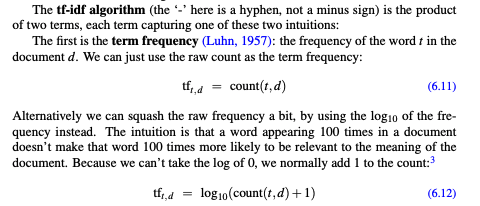

In [4]:
def get_term_frequencies(docs):
    tfreq = {}
    tfreqlog = {}
    
    for i, doc in enumerate(docs):
        tfd = Counter(doc.split())
        tfreq[i] = tfd
        
        tfdlog = deepcopy(tfd)
        
        # Take log10 of all the counts to normalize
        for k, v in tfdlog.items():
            tfdlog[k] = math.log10(v + 1)
            
        tfreqlog[i] = tfdlog
    
    return tfreq, tfreqlog

def get_normalized_term_frequencies(docs):
    tfreq = {}
    tfreq_norm = {}
    
    for i, doc in enumerate(docs):
        words = doc.split()
        doc_length = len(words)
        tfd = Counter(words)
        tfreq[i] = tfd
        
        tfdnorm = deepcopy(tfd)
        for k, v in tfdnorm.items():
            tfdnorm[k] /= doc_length
        
        tfreq_norm[i] = tfdnorm
    
    return tfreq, tfreq_norm

In [5]:
tfreq_d, tfreq_norm = get_normalized_term_frequencies(documents)

In [6]:
N = len(documents)  # 720
print(N)

def get_vocab(docs):
    words = []
    for doc in docs:
        words.extend(doc.split())
    
    terms = OrderedDict.fromkeys(words).keys()
    return terms, len(terms)

def get_idfs(docs, terms, tfreq_d, N):
    idf = {}
    
    for term in terms:
        df_t = 0
        for i, doc in enumerate(docs):
            if tfreq_d[i][term] > 0:
                df_t += 1
        
        idf[term] = math.log10(N/df_t)
    
    return idf

721


In [7]:
terms, vocab_size = get_vocab(documents)

idfs = get_idfs(documents, terms, tfreq_d, N)

In [8]:
def get_word_term_doc_matrix(terms, docs, tfreq_norm, idf):
    word_term_doc = []
    for term in terms:
        scores = [term]
        for i, doc in enumerate(documents):
            scores.append(tfreq_norm[i][term] * idf[term])

        word_term_doc.append(scores)
    
    return word_term_doc

def convert_to_df(word_term_doc, N):
    columns = ['term'] + [i for i in range(N)]
    return pd.DataFrame(word_term_doc, columns=columns).set_index(['term'])

In [9]:
word_term_doc = get_word_term_doc_matrix(terms, documents, tfreq_norm, idfs)
df = convert_to_df(word_term_doc, N)

In [10]:
def get_euclid_df_sklearn(df):
    no_index = df.reset_index(drop=True)
    values = [no_index.values[i] for i in range(N)]
    dist = euclidean_distances(values)
    return pd.DataFrame(dist)

def get_euclid_df_scipy(df):
    no_index = df.reset_index(drop=True)
    values = [no_index.values[i] for i in range(N)]
    dist = pdist(values, 'euclidean')
    return pd.DataFrame(squareform(dist))

In [11]:
euclid1 = get_euclid_df_sklearn(df)
euclid1

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,0.000000,0.274436,0.284132,0.215558,0.275640,0.279104,0.195912,0.206057,0.270123,0.259250,...,0.179073,0.178444,0.192353,0.211546,0.178444,0.178444,0.181296,0.182793,0.203577,0.239532
1,0.274436,0.000000,0.388757,0.148697,0.381456,0.391383,0.204074,0.296827,0.366203,0.354851,...,0.330724,0.330384,0.338099,0.349375,0.330384,0.330384,0.331933,0.332753,0.344609,0.366997
2,0.284132,0.388757,0.000000,0.323667,0.310322,0.250273,0.295348,0.294462,0.311332,0.313637,...,0.263740,0.263719,0.270906,0.284353,0.263719,0.263719,0.263326,0.264778,0.279626,0.302300
3,0.215558,0.148697,0.323667,0.000000,0.322822,0.322380,0.162390,0.229490,0.294403,0.264568,...,0.242637,0.242173,0.252597,0.267502,0.242173,0.242173,0.244282,0.245395,0.261245,0.290139
4,0.275640,0.381456,0.310322,0.322822,0.000000,0.274138,0.290917,0.290197,0.321841,0.309589,...,0.259849,0.259625,0.267440,0.275306,0.259625,0.259625,0.260587,0.262359,0.265818,0.301444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,0.178444,0.330384,0.263719,0.242173,0.259625,0.229346,0.197046,0.157781,0.220950,0.209989,...,0.017643,0.000000,0.055123,0.114821,0.000000,0.000000,0.034103,0.041762,0.099443,0.160549
717,0.181296,0.331933,0.263326,0.244282,0.260587,0.229242,0.199632,0.160999,0.223259,0.212418,...,0.029811,0.034103,0.063120,0.119587,0.034103,0.034103,0.000000,0.053649,0.104900,0.159377
718,0.182793,0.332753,0.264778,0.245395,0.262359,0.229987,0.200993,0.162683,0.221923,0.213697,...,0.045134,0.041762,0.072312,0.121943,0.041762,0.041762,0.053649,0.000000,0.107575,0.165737
719,0.203577,0.344609,0.279626,0.261245,0.265818,0.240403,0.220065,0.185731,0.240795,0.231726,...,0.100846,0.099443,0.116914,0.115209,0.099443,0.099443,0.104900,0.107575,0.000000,0.188626


In [12]:
def get_similarity_df(euclid_df, N):
    similarities = []
    for i in range(N):
        for j in range(i+1, N):
            dist = euclid_df[i][j] 
            similarities.append((i, j, dist))
    
    return pd.DataFrame(similarities)

In [13]:
similarities = get_similarity_df(euclid1, N)

In [14]:
similarities = similarities.sort_values(2)
similarities

,0,1,2
129779,211,226,0.000000
44729,65,75,0.000000
44734,65,80,0.000000
45381,66,73,0.000000
45383,66,75,0.000000
...,...,...,...
33610,48,227,0.744699
26163,37,227,0.778892
26115,37,179,0.780147
25480,36,227,0.793208


In [15]:
luigi = pd.read_csv('similarity.csv')

In [16]:
luigi

,0,1,2
0,211,226,0.000000
1,65,75,0.000000
2,65,80,0.000000
3,66,73,0.000000
4,66,75,0.000000
...,...,...,...
259555,48,227,0.744699
259556,37,227,0.778892
259557,37,179,0.780147
259558,36,227,0.793208
